In [1]:
import pandas as pd, numpy as np
from datetime import date, timedelta
import gc
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

## User Defined Functions

In [2]:
def comma_format(num):
    '''
    convert a number to comma format
    return is in string type
    '''
    return '{:,}'.format(num)

In [3]:
def reduce_mem_usage(df, verbose=True):
    '''
    takes in a dataframe and optimizes the data types of numeric columns according to the range of values in them
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2 # conversion from bytes to Mb
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('collecting garbage gc.collect()')
    gc.collect()
    if verbose:
        print('Memory usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(
            end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Importing Data

In [4]:
df = pd.read_csv('Data_Assignment.csv')

#### checking missing values

In [5]:
df.isna().sum()

Customer ID      0
Quantity         0
Invoice Value    0
Date             0
dtype: int64

**Inference**: no missing data

## Data Types

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240880 entries, 0 to 4240879
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Customer ID    int64  
 1   Quantity       float64
 2   Invoice Value  float64
 3   Date           object 
dtypes: float64(2), int64(1), object(1)
memory usage: 129.4+ MB


In [7]:
# converting to proper data type
# we did not make Customer ID 'category' as it was causing error in groupby
df['Customer ID'] = df['Customer ID'].astype('object')
df['Date'] = pd.to_datetime(df['Date'])

#### checking if Quantity and Invoice Value have any decimal values, so that we can convert it to int type for better memory handling

In [8]:
# checking if Quantity and Invoice Value have any decimal values
np.array_equal(df.Quantity, df.Quantity.astype(int))

False

In [9]:
# looking at data where Quantity is in decimal numbers
df_decimal_quantity = df[~df.Quantity.apply(float.is_integer)]

In [10]:
df_decimal_quantity.head()

,Customer ID,Quantity,Invoice Value,Date
5361,500009165,9.833,361.675,2019-03-12
9141,500041792,4.667,129.080,2018-06-09
19210,500070225,0.833,36.365,2018-06-28
22214,500064900,2.833,102.600,2019-02-19
48717,500055771,0.833,33.060,2018-10-18


In [11]:
# checking in the cost of per pack of noodle in cases where quantity is in decimal numbers
df_decimal_quantity['Price'] = df_decimal_quantity['Invoice Value']/df_decimal_quantity['Quantity']

<ipython-input-11-47d862aec71b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_decimal_quantity['Price'] = df_decimal_quantity['Invoice Value']/df_decimal_quantity['Quantity']


In [12]:
df_decimal_quantity.head()

,Customer ID,Quantity,Invoice Value,Date,Price
5361,500009165,9.833,361.675,2019-03-12,36.781755
9141,500041792,4.667,129.080,2018-06-09,27.658024
19210,500070225,0.833,36.365,2018-06-28,43.655462
22214,500064900,2.833,102.600,2019-02-19,36.216025
48717,500055771,0.833,33.060,2018-10-18,39.687875


In [13]:
del df_decimal_quantity

**Inference**:  
There are Quantities which are in decimal numbers. We should confirm what it means for better understanding of data generation process.  
There seems to be no apparent insight into Price of a Noodle pack in these cases.  

Hence we would have to leave it in float.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240880 entries, 0 to 4240879
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   Customer ID    object        
 1   Quantity       float64       
 2   Invoice Value  float64       
 3   Date           datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 129.4+ MB


In [15]:
df = reduce_mem_usage(df)

collecting garbage gc.collect()
Memory usage decreased to 80.89 Mb (37.5% reduction)


In [16]:
gc.collect()

20

## Feature Engineering  
creating all features we think may have had an impact on quantities of noodles a Customer purchases.

#### Date Features

In [17]:
# dates within month
df['dayofmonth'] = df['Date'].dt.day.astype('int16')

In [18]:
# The month as January=1, December=12
df['month'] = df['Date'].dt.month.astype('int16')

In [19]:
# week number of ordinal year
df['week'] = df['Date'].dt.week.astype('int16')

In [20]:
# The day of the week with Monday=0, Sunday=6.
df['dayofweek'] = df['Date'].dt.dayofweek

In [21]:
# year
df['year'] = df['Date'].dt.year.astype('int16')

In [22]:
# quarter
df['quarter'] = df['Date'].dt.quarter.astype('int16')

In [23]:
# first 7 days of a month are considered as start of month
# last 7 days of a month are considered as end of month
# rest are considered as mid of week
df['is_month_start'] = np.where(df['dayofmonth'] <= 7, 1, 0).astype("int16")
df['is_month_mid'] = np.where((df['dayofmonth'] >= 8) & (df['dayofmonth'] <= 21), 1, 0).astype("int16")
df['is_month_end'] = np.where(df['dayofmonth'] >= 22, 1, 0).astype("int16")

In [24]:
df['month_start_mid_end'] = 9

In [25]:
df.loc[df['is_month_start'] == 1, 'month_start_mid_end'] = 1
df.loc[df['is_month_mid'] == 1, 'month_start_mid_end'] = 2
df.loc[df['is_month_end'] == 1, 'month_start_mid_end'] = 3

In [26]:
df.drop(['is_month_start','is_month_mid','is_month_end'], axis=1, inplace=True)

In [27]:
df.head()

,Customer ID,Quantity,Invoice Value,Date,dayofmonth,month,week,dayofweek,year,quarter,month_start_mid_end
0,500743788,0.0,0.000,2018-12-04,4,12,49,1,2018,4,1
1,500747617,0.0,0.000,2018-12-27,27,12,52,3,2018,4,3
2,500748185,1.0,43.625,2018-12-04,4,12,49,1,2018,4,1
3,500701019,1.0,43.625,2018-12-09,9,12,49,6,2018,4,2
4,500052656,0.0,0.000,2018-12-13,13,12,50,3,2018,4,2


In [28]:
# optimizing memory of dataframe
df = reduce_mem_usage(df)
gc.collect()

collecting garbage gc.collect()
Memory usage decreased to 113.24 Mb (39.1% reduction)


0

### Creating sin cos components for cyclic features  
this is a way to encode cyclic features like month, day, quarter to sin and cos components and hence make these numerial and also maintain their cyclic property.

In [29]:
df['dayofmonth_sin'] = np.sin(df['dayofmonth']*((2*np.pi)/31))
df['dayofmonth_cos'] = np.cos(df['dayofmonth']*((2*np.pi)/31))
del df['dayofmonth']
gc.collect()
df = reduce_mem_usage(df)

collecting garbage gc.collect()
Memory usage decreased to 125.38 Mb (27.9% reduction)


In [30]:
df['month_sin'] = np.sin(df['month']*((2*np.pi)/12))
df['month_cos'] = np.cos(df['month']*((2*np.pi)/12))
#del df['month']
gc.collect()
df = reduce_mem_usage(df)

collecting garbage gc.collect()
Memory usage decreased to 141.55 Mb (25.5% reduction)


In [31]:
df['week_sin'] = np.sin(df['week']*((2*np.pi)/52))
df['week_cos'] = np.cos(df['week']*((2*np.pi)/52))
#df.drop(['week'], axis=1, inplace=True)
del df['week']
gc.collect()
df = reduce_mem_usage(df)

collecting garbage gc.collect()
Memory usage decreased to 153.69 Mb (24.0% reduction)


In [32]:
df['dayofweek_sin'] = np.sin(df['dayofweek']*((2*np.pi)/7))
df['dayofweek_cos'] = np.cos(df['dayofweek']*((2*np.pi)/7))
del df['dayofweek']
gc.collect()
df = reduce_mem_usage(df)

collecting garbage gc.collect()
Memory usage decreased to 165.82 Mb (22.6% reduction)


In [33]:
df['quarter_sin'] = np.sin(df['quarter']*((2*np.pi)/4))
df['quarter_cos'] = np.cos(df['quarter']*((2*np.pi)/4))
del df['quarter']
gc.collect()
df = reduce_mem_usage(df)

collecting garbage gc.collect()
Memory usage decreased to 177.95 Mb (21.4% reduction)


In [34]:
df['month_start_mid_end_sin'] = np.sin(df['month_start_mid_end']*((2*np.pi)/3))
df['month_start_mid_end_cos'] = np.cos(df['month_start_mid_end']*((2*np.pi)/3))
del df['month_start_mid_end']
gc.collect()
df = reduce_mem_usage(df)

collecting garbage gc.collect()
Memory usage decreased to 190.09 Mb (20.3% reduction)


In [35]:
# optimizing memory of dataframe
df = reduce_mem_usage(df)
gc.collect()

collecting garbage gc.collect()
Memory usage decreased to 190.09 Mb (0.0% reduction)


0

In [36]:
df.head()

,Customer ID,Quantity,Invoice Value,Date,month,year,dayofmonth_sin,dayofmonth_cos,month_sin,month_cos,week_sin,week_cos,dayofweek_sin,dayofweek_cos,quarter_sin,quarter_cos,month_start_mid_end_sin,month_start_mid_end_cos
0,500743788,0.0,0.000,2018-12-04,12,2018,0.724609,0.688965,-0.0,1.0,-0.354492,0.935059,0.781738,0.623535,-0.0,1.0,0.866211,-0.5
1,500747617,0.0,0.000,2018-12-27,12,2018,-0.724609,0.688965,-0.0,1.0,-0.000000,1.000000,0.433838,-0.900879,-0.0,1.0,-0.000000,1.0
2,500748185,1.0,43.625,2018-12-04,12,2018,0.724609,0.688965,-0.0,1.0,-0.354492,0.935059,0.781738,0.623535,-0.0,1.0,0.866211,-0.5
3,500701019,1.0,43.625,2018-12-09,12,2018,0.968262,-0.250732,-0.0,1.0,-0.354492,0.935059,-0.781738,0.623535,-0.0,1.0,-0.866211,-0.5
4,500052656,0.0,0.000,2018-12-13,12,2018,0.485352,-0.874512,-0.0,1.0,-0.239258,0.970703,0.433838,-0.900879,-0.0,1.0,-0.866211,-0.5


#### Price of a noodle pack   
provide justification for using price as an independent variable as price is decided by ABC ltd and is not a function of a transaction. This is a fair business assumption.

In [37]:
df['price'] = df['Invoice Value']/df['Quantity']

In [38]:
gc.collect()

60

### Imputing price where quantity is 0
as dividing by 0 would make NaN  
using business logic price can be derived from other orders, where there was a transaction, 
in the same time period as, the transaction where we want to impute the price  

we are immputing price with average price of a noodle pack per customer in the given month

In [39]:
# taking only those transactions where customer ordered 
df_sold = df[df.Quantity != 0][['Customer ID','month','year','price']]

In [40]:
# exporting all transactions where customer ordered for analysis
df_sold.shape
#df_sold.to_excel('df_sold.xlsx',index=False)

(239832, 4)

In [41]:
# this will give us average price of a noodle pack for each customer per transaction in the given year and month
df_avgprice_eachcustomer = df_sold.groupby(['year','month','Customer ID']).agg({'price':'mean'}).reset_index()

In [42]:
# this will give us average price of a noodle pack per customer per transaction in the given year and month
df_sold_averageprice = df_avgprice_eachcustomer.groupby(['year','month']).agg({'price':'mean'}).reset_index()

In [43]:
# exporting for analysis
#df_sold_averageprice.to_excel('monthly price.xlsx',index=False)

imputing in the main dataframe

In [44]:
del df_avgprice_eachcustomer

In [45]:
gc.collect()

60

In [46]:
df_merge = pd.merge(df,df_sold_averageprice,how='left',on=['year','month'],suffixes=('_transaction','_monthlyaverage'))

In [47]:
df_merge['price'] = df_merge['price_transaction']
df_merge.loc[df_merge['price_transaction'].isna(),'price'] = df_merge.loc[df_merge['price_transaction'].isna(),'price_monthlyaverage'] 

In [48]:
df = df_merge.drop(['price_transaction','price_monthlyaverage'],axis=1).copy()

In [49]:
# optimizing memory of dataframe
df = reduce_mem_usage(df)
gc.collect()

collecting garbage gc.collect()
Memory usage decreased to 254.80 Mb (-10.5% reduction)


0

In [50]:
# deleting intermediary dataframes no longer being used
del df_merge, df_sold_averageprice, df_sold

In [51]:
df.head()

,Customer ID,Quantity,Invoice Value,Date,month,year,dayofmonth_sin,dayofmonth_cos,month_sin,month_cos,week_sin,week_cos,dayofweek_sin,dayofweek_cos,quarter_sin,quarter_cos,month_start_mid_end_sin,month_start_mid_end_cos,price
0,500743788,0.0,0.000,2018-12-04,12,2018,0.724609,0.688965,-0.0,1.0,-0.354492,0.935059,0.781738,0.623535,-0.0,1.0,0.866211,-0.5,43.46875
1,500747617,0.0,0.000,2018-12-27,12,2018,-0.724609,0.688965,-0.0,1.0,-0.000000,1.000000,0.433838,-0.900879,-0.0,1.0,-0.000000,1.0,43.46875
2,500748185,1.0,43.625,2018-12-04,12,2018,0.724609,0.688965,-0.0,1.0,-0.354492,0.935059,0.781738,0.623535,-0.0,1.0,0.866211,-0.5,43.62500
3,500701019,1.0,43.625,2018-12-09,12,2018,0.968262,-0.250732,-0.0,1.0,-0.354492,0.935059,-0.781738,0.623535,-0.0,1.0,-0.866211,-0.5,43.62500
4,500052656,0.0,0.000,2018-12-13,12,2018,0.485352,-0.874512,-0.0,1.0,-0.239258,0.970703,0.433838,-0.900879,-0.0,1.0,-0.866211,-0.5,43.46875


In [52]:
# optimizing memory of dataframe
df = reduce_mem_usage(df)
gc.collect()

collecting garbage gc.collect()
Memory usage decreased to 254.80 Mb (0.0% reduction)


0

## Exploratory Data Analysis  

In [53]:
print(f'Total no. of rows we have: {comma_format(df.shape[0])}')
print(f'Total no. of unique Customer IDs we have: ',comma_format(len(df['Customer ID'].unique())))

Total no. of rows we have: 4,240,880
Total no. of unique Customer IDs we have:  73,413


#### there are customers which have never bought from ABC Ltd even after multiple visits from sales representative
it is a business assumption that they will not buy from ABC   
so these will be separated and their estimation will be zero quantity always

#### export to excel for plotting 
**average price of a noodle pack per customer vs average quantity ordered per customer**

In [54]:
df.head()

,Customer ID,Quantity,Invoice Value,Date,month,year,dayofmonth_sin,dayofmonth_cos,month_sin,month_cos,week_sin,week_cos,dayofweek_sin,dayofweek_cos,quarter_sin,quarter_cos,month_start_mid_end_sin,month_start_mid_end_cos,price
0,500743788,0.0,0.000,2018-12-04,12,2018,0.724609,0.688965,-0.0,1.0,-0.354492,0.935059,0.781738,0.623535,-0.0,1.0,0.866211,-0.5,43.46875
1,500747617,0.0,0.000,2018-12-27,12,2018,-0.724609,0.688965,-0.0,1.0,-0.000000,1.000000,0.433838,-0.900879,-0.0,1.0,-0.000000,1.0,43.46875
2,500748185,1.0,43.625,2018-12-04,12,2018,0.724609,0.688965,-0.0,1.0,-0.354492,0.935059,0.781738,0.623535,-0.0,1.0,0.866211,-0.5,43.62500
3,500701019,1.0,43.625,2018-12-09,12,2018,0.968262,-0.250732,-0.0,1.0,-0.354492,0.935059,-0.781738,0.623535,-0.0,1.0,-0.866211,-0.5,43.62500
4,500052656,0.0,0.000,2018-12-13,12,2018,0.485352,-0.874512,-0.0,1.0,-0.239258,0.970703,0.433838,-0.900879,-0.0,1.0,-0.866211,-0.5,43.46875


In [55]:
# taking only data points where we sold noodles 
# this is done so that we can get price and quantity estimates correct without any 0 values in between
df_sold = df[df.Quantity != 0]

In [56]:
df_sold_group = df_sold[['Customer ID','Date','Quantity','price']].groupby('Date').mean().reset_index()

In [57]:
#df_group.sort_values('Date').to_excel('df_sold_group.xlsx',index=False)

In [58]:
del df_sold, df_sold_group

**Inference**:  
slightly increase in price of noodles. We can clearly see the dates around which the prices were increased. Show average price and increase in a table.  
except for one outlier, we see that demand has more or less stable, despite increase in price.  
Also, there are peaks in quantity ordered around the date prices were increased. This could point towards marketing such as (rebranding and increasing price), promotions etc.  
if we could know this for incoming data, we can also add this as feature.

#### export to plot histogram of counts 

In [59]:
#df['Customer ID'].value_counts().to_excel('CustomerID_Counts.xlsx')

**Inference**:  
histogram of the count or number of times a customer bought from the ABC Ltd.  
There come out three different categories of customers:  
1. those who bought a lot
2. those who bought some
3. those who bought very less 

Make segment the cusotmers in categories using k-means clustering with 3 clusters and value counts as the only numerical variable. Calculate average quantity ordered per customer per day for each cluster.  
Create a feature for each customer with the calculate average quantity for the cluster in which the customer belongs.

There are many customers. Ideally such model would work better if we trained one for each Customer as behaviour of each Customer is different.  
There are two main challenges for not being able to this:  
1. Not each Customers have enough data points, the max data points we have are for customer 500015112 which is 368.
2. Also there too are many customers to do this for each customer in the given time. 60,921 out of 73,413 i.e. 83% have less than 100 data points.

### average visits ABC Ltd salesman makes to customers in a month

# Modelling

## Train and Test Data  
Training Data:  Jan 2018 - Dec 2018, Test Data:  Jan 2019 - Mar 2019

In [60]:
df.Date.min()

Timestamp('2018-01-02 00:00:00')

In [61]:
df.Date.max()

Timestamp('2019-03-31 00:00:00')

In [62]:
df.shape

(4240880, 19)

In [63]:
df_train = df[df['year'] == 2018]

In [64]:
df_test = df[df['year'] == 2019]

In [65]:
df_train.to_csv('df_train.csv',index=False)

In [66]:
df_test.to_csv('df_test.csv',index=False)

### Customer Clusters Feature  
There are customers which have never bought from ABC ltd. These customers are not expected to start buying and hence the estimation for these will be fixed at 0

After removing above customers, upon lookinng at the hsitogram of number of time ABC ltd sales visits a customer, all customers can be segmented in three different clusters.  
1. with high visits
2. with medium visits
3. with low visits

customers who never ordered from ABC, despite ABC sales representative visiting them atleast once.  
Quantitiy estimation for them will always be 0 as there may be some unspecified reason for them to not order from ABC ltd.

New customers will be added tagged to clusters with low visits.

## K-Means clustering on count of visits and average quantity per visit

In [67]:
df_train_group = df_train.groupby(['Customer ID']).agg({'Quantity':['sum','count']}).reset_index()

In [68]:
df_train_group.columns = ['Customer ID','Quantity_Sum','Quantity_Count']

In [69]:
df_train_group['AverageQuantityPerVisit'] = df_train_group['Quantity_Sum']/df_train_group['Quantity_Count']

In [70]:
x = df_train_group.loc[:,['Quantity_Count','AverageQuantityPerVisit']].values

### using elbow method to find optimal no. of clusters

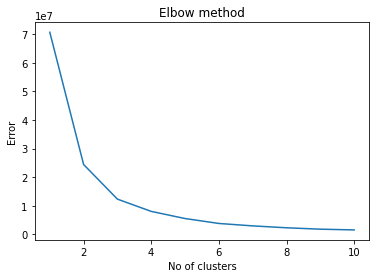

In [71]:
Error =[]

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i).fit(x)
    kmeans.fit(x)
    Error.append(kmeans.inertia_)

plt.plot(range(1, 11), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

**Inference**  
3 clusters seems optimal, as expected

In [72]:
kmeans3 = KMeans(n_clusters=3)
y_kmeans3 = kmeans3.fit_predict(x)
print(y_kmeans3)

kmeans3.cluster_centers_

[2 0 1 ... 2 2 2]


array([[4.86949061e+01, 8.97949148e-02],
       [9.26017285e+01, 1.51589810e-01],
       [1.59410348e+01, 8.26644188e-02]])

Text(0, 0.5, 'Average Quantity per Visit')

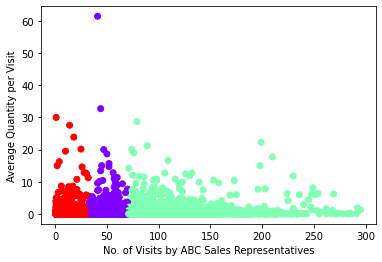

In [73]:
plt.scatter(x[:,0],x[:,1], c=y_kmeans3, cmap='rainbow')
plt.xlabel('No. of Visits by ABC Sales Representatives')
plt.ylabel('Average Quantity per Visit')

In [74]:
y_kmeans3

array([2, 0, 1, ..., 2, 2, 2])

In [75]:
df_train_group['Customer_Cluster'] = y_kmeans3

In [76]:
df_train_group.Customer_Cluster.unique()

array([2, 0, 1])

In [77]:
# cluster number that came out of kmeans is 1=high visist,2=medium visit,0=low visit
# we want opposite order i.e. 3=High Visits, 2=Medium Visits, 1=Low Visits
df_train_group.loc[df_train_group['Customer_Cluster'] == 1,'Customer_Cluster'] = 3
df_train_group.loc[df_train_group['Customer_Cluster'] == 0,'Customer_Cluster'] = 1

In [78]:
df_train_group.Customer_Cluster.unique()

array([2, 1, 3])

In [79]:
df_train_group.to_csv('customer_cluster_train.csv',index=False)

In [80]:
gc.collect()

2787

In [81]:
del y_kmeans3,df_train_group

## Assigning customer clusters to test data

**any new customer will be assigned to customer cluster 1 as it is the one with lowest visits**

**This dataframe has all the customers for which estimation will always be 0 as they have never bought from ABC in past**

In [82]:
df_train_group_quantity = df_train.groupby(['Customer ID']).agg({'Quantity':'max'}).reset_index()

In [83]:
df_train_zero_qty_customers = df_train_group_quantity[df_train_group_quantity['Quantity'] == 0]

In [84]:
df_train_zero_qty_customers.to_csv('df_train_zero_qty_customers.csv',index=False)

In [85]:
df_train_zero_qty_customers.shape

(37618, 2)

In [86]:
# taking only customers which have ordered with ABC ltd in past
df_train_regress = df_train[~df_train['Customer ID'].isin(df_train_zero_qty_customers['Customer ID'].unique())]

In [87]:
df_train_regress = reduce_mem_usage(df_train_regress)
gc.collect()

<ipython-input-3-7c16533c7d78>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(np.float16)
<ipython-input-3-7c16533c7d78>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(np.int16)


collecting garbage gc.collect()
Memory usage decreased to 117.58 Mb (0.0% reduction)


<ipython-input-3-7c16533c7d78>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(np.float64)


0

In [88]:
df_train_regress.to_csv('df_train_regress.csv',index=False)

Suggestion: no. of days from previous visit can also be a feature

In [89]:
df_train_regress = reduce_mem_usage(df_train_regress)

<ipython-input-3-7c16533c7d78>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(np.float16)
<ipython-input-3-7c16533c7d78>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(np.int16)


collecting garbage gc.collect()
Memory usage decreased to 117.58 Mb (0.0% reduction)


<ipython-input-3-7c16533c7d78>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(np.float64)


In [90]:
df_train_regress.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1957002 entries, 0 to 4240877
Data columns (total 19 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   Customer ID              object        
 1   Quantity                 float16       
 2   Invoice Value            float16       
 3   Date                     datetime64[ns]
 4   month                    int8          
 5   year                     int16         
 6   dayofmonth_sin           float16       
 7   dayofmonth_cos           float16       
 8   month_sin                float16       
 9   month_cos                float16       
 10  week_sin                 float16       
 11  week_cos                 float16       
 12  dayofweek_sin            float16       
 13  dayofweek_cos            float16       
 14  quarter_sin              float16       
 15  quarter_cos              float16       
 16  month_start_mid_end_sin  float16       
 17  month_start_mid_end_cos  fl